<a href="https://colab.research.google.com/github/fire-long/4J/blob/model4/%EB%AA%A8%EB%8D%B8%EB%A7%814_%EB%B0%95%EC%A7%84%EC%98%81_huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging Face를 활용한 Modeling
Google Colab과 Pytorch, Hugging Face Trainer를 사용하여 Model Fine-tuning과 Inference를 진행해보자
- ROBERTa : BERT 기반 모델. 공통적으로 transformer encoder를 사용하지만, pre-training을 MLM(Masked Language Model)에 좀 더 특화된 모델이라고 생각해주면 됨.

## EDA(Exploratory Data Analysis)
간단하게 Train, Test Dataset의 구조와 문장 분포를 확인해보았습니다.

### Import Package
데이터 확인을 위한 패키지 불러오기

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load Data
Data가 위치한 PATH에서 Data를 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH =  '/content/drive/MyDrive/JJJJ/model4'

train = pd.read_csv(os.path.join(PATH, 'train_data.csv'), encoding='utf-8')
test = pd.read_csv(os.path.join(PATH, 'test_data.csv'), encoding='utf-8')
#train = pd.read_csv('train_data.csv', encoding = 'utf-8')
#test = pd.read_csv('test_data.csv', encoding = 'utf-8')

train.head(5)

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


### Train, Test Data 확인

In [ ]:
print(train.info(), end='\n\n')
#다음 출력값을 \n\n으로 이어감.즉, 출력한 내용 사이에 빈 줄을 추가
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       24998 non-null  int64 
 1   premise     24998 non-null  object
 2   hypothesis  24998 non-null  object
 3   label       24998 non-null  object
dtypes: int64(1), object(3)
memory usage: 781.3+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1666 non-null   int64 
 1   premise     1666 non-null   object
 2   hypothesis  1666 non-null   object
 3   label       1666 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB
None


In [ ]:
print('Train Columns: ', train.columns)
print('Test Columns: ', test.columns)

Train Columns:  Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')
Test Columns:  Index(['index', 'premise', 'hypothesis', 'label'], dtype='object')


In [ ]:
print('Train Label: ', train['label'].value_counts(), sep='\n', end='\n\n')
print('Test Label: ', test['label'].value_counts(), sep='\n')

Train Label: 
entailment       8561
contradiction    8489
neutral          7948
Name: label, dtype: int64

Test Label: 
answer    1666
Name: label, dtype: int64


In [ ]:
print('Train Null: ', train.isnull().sum(), sep='\n', end='\n\n')
print('Test Null: ', test.isnull().sum(), sep='\n')

Train Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64

Test Null: 
index         0
premise       0
hypothesis    0
label         0
dtype: int64


### Label 분포
Train Dataset의 Label 분포를 Bar Chart를 사용하여 시각화

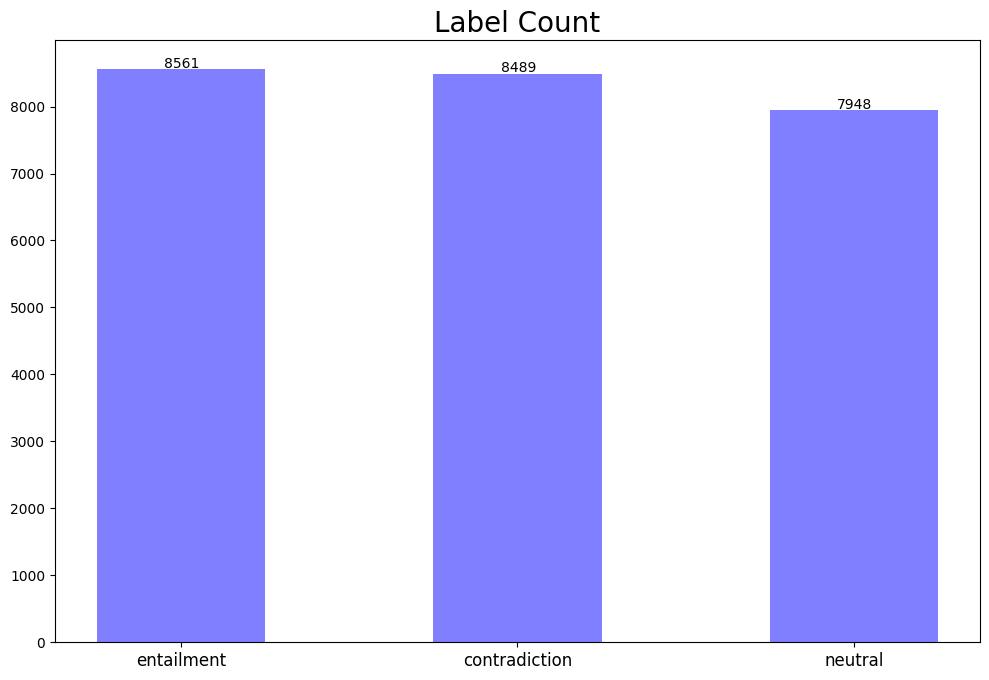

In [ ]:
feature = train['label']

plt.figure(figsize=(10,7.5))
plt.title('Label Count', fontsize=20)

temp = feature.value_counts()
plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5)
plt.text(-0.05, temp.values[0]+20, s=temp.values[0])
plt.text(0.95, temp.values[1]+20, s=temp.values[1])
plt.text(1.95, temp.values[2]+20, s=temp.values[2])

plt.xticks(temp.keys(), fontsize=12) # x축 값, 폰트 크기 설정
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정
plt.show() # 그래프 나타내기

### 전제, 가설 길이 확인
Train에 존재하는 Premise(전제), Hypothesis(가설)의 길이를 확인하고 이를 통해 Tokenizer의 max_length 설정이 가능

In [ ]:
max_len = np.max(train['premise'].str.len())
min_len = np.min(train['premise'].str.len())
mean_len = np.mean(train['premise'].str.len())

print('Max Premise Length: ', max_len)
print('Min Premise Length: ', min_len)
print('Mean Premise Lenght: ', mean_len, '\n')

max_len = np.max(train['hypothesis'].str.len())
min_len = np.min(train['hypothesis'].str.len())
mean_len = np.mean(train['hypothesis'].str.len())

print('Max Hypothesis Length: ', max_len)
print('Min Hypothesis Length: ', min_len)
print('Mean Hypothesis Lenght: ', mean_len)

Max Premise Length:  90
Min Premise Length:  19
Mean Premise Lenght:  45.406552524201935 

Max Hypothesis Length:  103
Min Hypothesis Length:  5
Mean Hypothesis Lenght:  24.924433954716378


Counter class : 시퀀스 자료형 (list, tuple, string 등) 에서 각 원소들의 개수를 셀 때 유용한 클래스

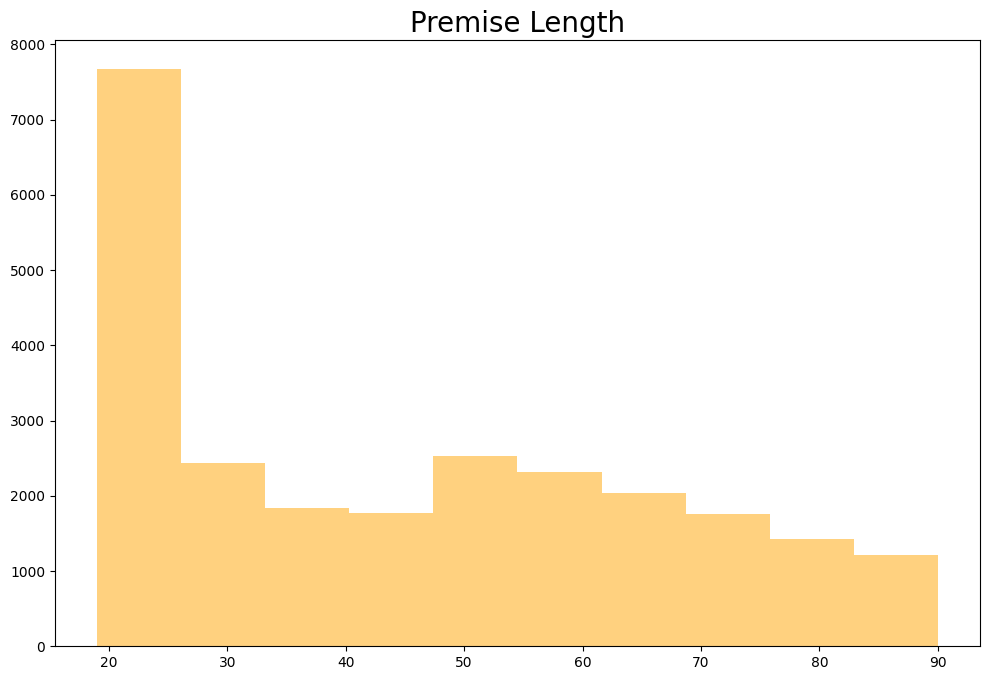

In [ ]:
from collections import Counter

plt.figure(figsize=(10,7.5))
plt.title('Premise Length', fontsize=20)

plt.hist(train['premise'].str.len(), alpha=0.5, color='orange')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 레이아웃 설정

plt.show()

### 간단한 Test Preprocessing
전제, 가설에 존재하는 한글 단어가 아닌 다른 단어들은 전부 제거해줍니다.

.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
- [^ ]: 대괄호 안의 ^ 기호는 not을 의미.
- ㄱ-ㅎㅏ-ㅣ가-힣 0-9: 한글 자음, 모음, 한글 글자, 영문 대소문자, 숫자, 공백을 의미

In [ ]:
train['premise'] = train['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['premise'] = test['premise'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

<ipython-input-15-2d3af709e460>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['premise'] = train['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
<ipython-input-15-2d3af709e460>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['premise'] = test['premise'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")


,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다.,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [ ]:
train['hypothesis'] = train['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['hypothesis'] = test['hypothesis'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

<ipython-input-16-7d1dabf81269>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train['hypothesis'] = train['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
<ipython-input-16-7d1dabf81269>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test['hypothesis'] = test['hypothesis'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")


,index,premise,hypothesis,label
0,0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다,contradiction
1,1,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다,neutral
4,4,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다,neutral


## Modeling

### Download transformers and Import Package

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.0 MB/s eta 0:00:00


In [ ]:
import os
import random
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

### Seed 고정, GPU 설정

딥러닝 모델 학습할 때, CPU보다 CUDA 디바이스가 더 빠르고 사용하기 좋음.

In [ ]:
def seed_everything(seed:int = 1004):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything(42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#현재 시스템에서 GPU(CUDA)를 사용할 수 있는지 여부를 확인하고, 사용 가능한 경우 CUDA 디바이스를 선택함
# 가능한 경우 "cuda:0"이라는 CUDA 디바이스를 선택하고, 그렇지 않으면 "cpu" 디바이스를 선택함
print(device)

cuda:0


### Load Tokenizer, Model
Hugging Face Hub에 존재하는 Pretrained Tokenizer와 Model 및 Model Config를 불러옵니다.

이 때, Classification은 num_labels가 2로 Default되어있기 때문에 Model Config의 Parameter를 변경해줍니다.

"klue/roberta-large"와 "klue" 모델 : 모두 KcBERT(Korean commonsense pre-trained BERT) 모델을 기반
- "klue/roberta-large"는 "klue" 모델보다 더 큰 사이즈의 모델
- klue는 데이터셋도 제공하므로, 표현에 혼동하지 않기!

In [ ]:
#klue/roberta-large 모델을 불러와서 출력
MODEL_NAME = 'klue/roberta-large'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)#해당 모델의 tokenizer를 불러옴

#해당 모델의 설정 정보를 불러와서 라벨 수를 3으로 변경
config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 3

#위에서 설정한 tokenizer와 설정 정보를 이용하여 모델을 불러옴
#AutoModelForSequenceClassification 클래스의 객체를 생성할 때, model() 함수가 생성됨.
#해당 함수가 호출될 때, 입력으로 데이터를 전달하면 내부적으로 forward() 함수가 호출되어
#모델이 입력데이터를 처리하고 출력값을 반환함.
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

#모델과 설정 정보 출력
print(model)
print(config)

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'cl

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

### Tokenizing
Train Data를 Train과 Validation Dataset으로 나누고 각각 데이터를 Tokenizer를 통해 Tokenizing을 합니다.

Tokenizer에 들어가는 문장은 전제와 가설을 Concat한 문장이 됩니다.

In [ ]:
train_dataset, eval_dataset = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['label'])
#훈련셋과 평가셋으로 나눔
#stratify=train['label']:클래스별로 데이터를 층을 내 샘플링하여 골고루 데이터를 추출함.


# premise와 hypothesis 문장 쌍을 토큰화해서 tokenized_train과 tokenized_eval 데이터셋 생성
'''
max_length을 256으로 설정하는 이유는,
- 256이 대부분의 NLP 모델에서 사용되는 토큰 최대 길이이기 때문임.
- 패딩을 쉽게 처리하기 위해서기도 함.
  (최대길이보다 짧은 문장은 나머지 부분을 패딩토큰으로 채워줘야하는데,
  2의 제곱수로 설정하면 이 작업이 더 효율적으로 처리됨.)
'''
'''
    padding : 모델의 입력 데이터를 일정 길이로 맞추고자 짧은 문장에 부족한 길이를 0으로 채움.
              즉, 패딩 토큰을 추가
    truncation : padding과 목적은 동일하나 긴 문장을 잘라내는 작업만을 말함.
    add_special_tokens : 특별한 의미를 가진 토큰을 입력 데이터에 추가하는 작업
      - [CLS] : 문장의 시작을 나타냄
      - [SEP] : 문장 간 구분 역할
      특수 토큰은 모델학습에 필수적이고, 입력데이터의 양쪽 끝에 추가됨.
      RoBERTa 모델에서는 <s> 토큰을 문장의 시작을 알리는 특별한 토큰으로 사용
'''
tokenized_train = tokenizer(
    list(train_dataset['premise']),
    list(train_dataset['hypothesis']),
    return_tensors="pt", #PyTorch Tensor를 반환하게 함
    max_length=256, # Max_Length = 190
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_eval = tokenizer(
    list(eval_dataset['premise']),
    list(eval_dataset['hypothesis']),
    return_tensors="pt",
    max_length=256,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

#tokenizer 후, 0번째 인덱스의 데이터의 input_ids를 출력하고, 이를 다시 decode해서 본 문장으로 변환함.
#tokenization 과정에서 어떤 변화가 일어났는지 확인 가능.
'''
tokenization에선 문장을 subword로 나누고, 각 subword를 숫자로 변환하는 작업이 수행됨.
이때, input_ids는 각 subword를 대응하는 숫자 id로 변환된 결과를 나타냄.
'''
print(tokenized_train['input_ids'][0])
#첫 번째 데이터의 subword들을 숫자 id로 변환한 결과를 리스트 형태로 담음. 즉, tokenization 이후의 결과물
print(tokenizer.decode(tokenized_train['input_ids'][0]))
#이를 decode 함수를 사용하여 다시 원래의 문장으로 변환하면, subword에서 숫자 id로 변환한 과정에서 생긴 변화를 다시 원래 문장으로 돌릴 수 있음

tensor([    0, 30941,  2116, 11753,  5875, 12989,  2079, 14548,  2179,  3756,
         6941,  1510,  2103,  2291,  6911,  2522,  1432,  2348,  2284,  2052,
         7245,  3803,     2, 12989,  2145,  1510,  2103,  2291,  2073,  4273,
         2470,  1536,  2052,  1415,  2062,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])
[CLS] 이정재가 삼성그룹 부회장 이재용의 전처인 대상그룹 임세령 상무와 열애중이라고 합니다 [SEP] 이재용과 임세령은 결혼한 적이 없다 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

PyTorch의 Dataset 클래스를 상속하여 새로운 데이터셋 클래스인 BERTDataset을 정의

In [ ]:

class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
      #초기화
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
      #모델의 입력 데이터를 처리하는 데 필요한 method
      #인덱스를 입력으로 받아 데이터셋에서 해당 인덱스에 해당하는 샘플을 반환
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        #pair_dataset : 입력문장 쌍을 포함하는 dict
        #item은 pair_dataset에서 해당 인덱스에 해당하는 문장쌍을 가져와서 'clone().detach()'로 복사함
        item['label'] = torch.tensor(self.label[idx])
        #item['labl']에 해당 인덱스의 레이블값 저장
        return item

    def __len__(self):
      #데이터셋의 크기를 반환하는 method
        return len(self.label)

In [ ]:
def label_to_num(label):
  #label 컬럼에 해당하는 값을 인자로 받아서 레이블을 정수로 바꿔주는 함수
    label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])

    return num_label


train_label = label_to_num(train_dataset['label'].values)
eval_label = label_to_num(eval_dataset['label'].values)

In [ ]:
#위에서 만든 BERTDataset 함수로 train_dataset과 eval_dataset을 만들었음.
train_dataset = BERTDataset(tokenized_train, train_label)
eval_dataset = BERTDataset(tokenized_eval, eval_label)

#__len__, __getitem__ 메소드 사용

#문장 쌍의 개수를 출력
print(train_dataset.__len__())

#train_dataset에서 19997번째 문장쌍을 출력함
print(train_dataset.__getitem__(19997))


#해당 데이터의 input_ids를 tokenization 이전 상태로 디코딩하여 출력
#디코딩된 문장을 보면 [CLS]와 [SEP] 토큰이 추가되어 있으며, [PAD] 토큰이 추가되어 길이가 256이 되도록 padding됨
print(tokenizer.decode(train_dataset.__getitem__(19997)['input_ids']))


19998
{'input_ids': tensor([    0, 22748,  2255, 19418, 12830,  2256,  2079, 16878,  6385,  7873,
         2170,  3708,  4713,  2999,  7285,  7389,  2371,  2062,     2, 22748,
         2255, 19418, 12830,  2256,  2259, 17291,  2318,  7873,  2371,  2062,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def compute_metrics(pred):
  """ validation을 위한 metrics function """
  '''
  Hugging Face의 Transformers 라이브러리에서는 학습 시 validation을 수행할 때 Trainer 클래스를 사용함
  해당 클래스에선 compute_metrics 함수를 인자로 받아서 validation set의 예측결과와 정답값을 이용해 평가 지표를 계산함

  -> 함수의 입력값인 pred:
     'Trainer' 클래스에서 검증 셋의 batch별로 inference(학습된 모델이 파라미터를
     이용해 새로운 입력 데이터에 대한 예측을 수행)한 결과를 모은 객체

     (* batch 단위로 입력 데이터를 묶어서 연산을 수행해 속도를 향상시킴)
  '''
  labels = pred.label_ids #정답 라벨의 id값들
  preds = pred.predictions.argmax(-1) #예측 결과의 logit값을 담은 tensor
  #logit : 모델의 출력값 중 하나. 클래스 분류 문제에서 클래스의 개수와 같은 차원으로 출력됨
         #값이 클수록 해당클래스일 확률이 높은 것
  #predictions.argmax(-1): predictions의 마지막 차원에 따라 가장 큰 값을 지닌 인덱스를 반환함.
  #즉, 모델이 분류하려는 클래스 중에서 가장 높은 확률을 가지는 클래스의 인덱스를 반환
         #argmax():주어진 축(axis)에 따라 가장 큰 값을 가진 인덱스를 반환하는 함수
                  #파이토치에선 주어진 텐서의 가장 큰 값을 가진 인덱스르 반환함
  probs = pred.predictions

  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.
  # acc : labels와 preds의 값을 비교해 같은 경우의 수를 전체 케이스 수로 나눈 값
  return {
      'accuracy': acc,
  }

In [ ]:
#Trainer 클래스를 이용해 모델 학습을 위한 설정을 진행함.
#이전까지의 작업은 대체로 Trainer 사용을 위해 전처리 작업이 진행된 것

#학습에 필요한 arguments 설정
training_ars = TrainingArguments(
    output_dir='./result', #모델 체크포인트 및 로그 저장 디렉토리 경로
    num_train_epochs=7, #epochs
    per_device_train_batch_size=32, #batch size
    save_total_limit=5, #최대로 저장할 체크포인트 개수
    save_steps=500, #일정한 스텝마다 체크포인트 저장
    evaluation_strategy='steps',#evaluation을 언제 수행할지 결정. 여기선 일정 step마다 진행
    eval_steps = 500,#일정한 스텝마다 evaluation 수행
    load_best_model_at_end = True,#학습 종료 후 최고 성능을 보인 모델 불러오기 여부
)

#모델 학습을 실행하는 Trainer.
#데이터를 per_device_train_batch_size 개수만큼씩 잘라서 학습
trainer = Trainer(
    model=model,
    args=training_ars,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train() #학습을 시작하는 method
model.save_pretrained('./result/best_model') #최고 성능 모델을 해당 경로에 저장하는 method
#모델의 가중치(weight)와 tokenizer 정보도 함께 저장

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy
500,0.556700,0.392127,0.857600
1000,0.327600,0.453490,0.863400
1500,0.232700,0.579476,0.863600
2000,0.167900,0.531621,0.871600
2500,0.120800,0.526319,0.882400
3000,0.072000,0.602905,0.884200
3500,0.036200,0.668987,0.892800
4000,0.027700,0.712474,0.890400


In [ ]:
#GPU가 사용 가능하면 GPU를, 아니면 CPU를 사용하도록 설정
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#로버타(RoBERTa) 모델의 토크나이저명을 설정하고, 이전에 학습해준 ROBERTa 모델의 토크나이저를 불러옴
Tokenizer_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

#이전에 학습해준 ROBERTa의 경로를 지정하여 모델을 불러주고
MODEL_NAME = './result/checkpoint-4000'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

#해당 모델의 tokenizer와 임베딩 크기가 일치하도록 조정해줌
model.resize_token_embeddings(tokenizer.vocab_size)

#모델의 GPU나 CPU를 옮기는 코드
model.to(device)


print(tokenizer)

BertTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)


In [ ]:
#test 데이터셋의 레이블 데이터를 수치화
test_label = label_to_num(test['label'].values)

#tokenizer로 test 데이터셋을 토큰화하고 tokenized_test에 저장함.
tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt", #PyTorch tensor 형식으로 반환됨
    max_length=128,#토큰화된 데이터의 최대 길이
    padding=True,
    truncation=True,
    add_special_tokens=True
)
#tokenized_test와 test_label을 사용하여 test_dataset을 생성
test_dataset = BERTDataset(tokenized_test, test_label)

#__len__과 __getitem__ 메서드를 통해 데이터셋의 크기와 데이터를 조회
print(test_dataset.__len__())
print(test_dataset.__getitem__(1665)) #토큰화된 데이터를 이용하여 딕셔너리 형태의 1665번째 쌍 아이템을 반환
print(tokenizer.decode(test_dataset.__getitem__(6)['input_ids']))#토큰화된 데이터를 다시 텍스트 형식으로 변환

1666
{'input_ids': tensor([    0,   720,  3994,  2052, 10428,  2775,   647,  3657,  2119,  1085,
            3,     2,   720,  3994,  2052,   911,  2075,  3669,  2119,  3926,
         2088,  1513,  2359, 13964,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

 test 데이터셋을 이용해 예측 결과를 도출하는 코드

In [ ]:
#. DataLoader를 이용하여 배치 단위로 데이터를 가져와 모델에 입력으로 넣음
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval() #모델을 evaluation mode로 설정
output_pred = []
output_prob = []

#모델의 출력 결과를 이용해 예측한 결과와 확률값을 추출
#enumerate으로 DataLoader에서 하나씩 batch 데이터를 가져옴
for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():# with torch.no_grad()를 사용하여 autograd 역전파를 수행하지 않음
     #각 batch의 input_ids, attention_mask, token_type_ids를 GPU로 이동시킴
        outputs = model(
            input_ids=data['input_ids'].to(device),
            attention_mask=data['attention_mask'].to(device),
            token_type_ids=data['token_type_ids'].to(device)
        )
    '''
    forward 함수를 호출함
    이유 : DataLoader는 입력 데이터를 모델의 forward 함수에 넣고 예측값을 반환함
    DataLoader의 for문에서 모델에 입력 데이터를 전달하는 부분이 forward 함수를 호출하는 부분
    evaluation 모드로 설정되어 있어서,
    forward 함수를 호출할 때 모델이 가지고 있는 파라미터들이 업데이트되지 않음
    '''
    logits = outputs[0]
    #logits를 softmax해서 확률값으로 변환하고 prob에 저장
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()

    #logits도 CPU로 이동시키고 numpy() method 호출해서 result에 저장함.
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    # output_pred와 output_prob에 결과를 저장
    output_pred.append(result)
    output_prob.append(prob)

#pred_answer와 output_prob에 합쳐진 리스트를 저장
pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()
print(pred_answer)

100%|██████████| 105/105 [00:23<00:00,  4.56it/s]

[1, 2, 0, 1, 1, 2, 2, 0, 0, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 1, 2, 0, 0, 1, 2, 0, 0, 0, 2, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 2, 0, 0, 2, 2, 1, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 1, 2, 0, 1, 0, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 2, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 1, 2, 2, 2, 0, 1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2, 1, 1, 0, 2, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2, 1, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 1, 0, 2, 0, 1, 0, 2, 0, 1, 1, 1, 2, 2, 2, 0, 2, 0, 1, 0, 2, 1, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 1, 2, 1, 1, 2, 0, 0, 

In [ ]:
#숫자로 된 라벨을 해당하는 문자열 라벨로 다시 바꿔주는 함수
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])

    return str_label

answer = num_to_label(pred_answer)
print(answer)

[[0, 'contradiction'], [1, 'neutral'], [2, 'entailment'], [3, 'contradiction'], [4, 'contradiction'], [5, 'neutral'], [6, 'neutral'], [7, 'entailment'], [8, 'entailment'], [9, 'neutral'], [10, 'contradiction'], [11, 'entailment'], [12, 'contradiction'], [13, 'entailment'], [14, 'neutral'], [15, 'neutral'], [16, 'contradiction'], [17, 'neutral'], [18, 'contradiction'], [19, 'neutral'], [20, 'contradiction'], [21, 'neutral'], [22, 'entailment'], [23, 'entailment'], [24, 'contradiction'], [25, 'neutral'], [26, 'entailment'], [27, 'entailment'], [28, 'entailment'], [29, 'neutral'], [30, 'contradiction'], [31, 'contradiction'], [32, 'contradiction'], [33, 'neutral'], [34, 'neutral'], [35, 'contradiction'], [36, 'contradiction'], [37, 'contradiction'], [38, 'entailment'], [39, 'contradiction'], [40, 'neutral'], [41, 'entailment'], [42, 'entailment'], [43, 'neutral'], [44, 'neutral'], [45, 'contradiction'], [46, 'neutral'], [47, 'entailment'], [48, 'contradiction'], [49, 'entailment'], [50, '

In [ ]:
df = pd.DataFrame(answer, columns=['index', 'label'])

df.to_csv('./result/submission.csv', index=False)

print(df)

      index          label
0         0  contradiction
1         1        neutral
2         2     entailment
3         3  contradiction
4         4  contradiction
...     ...            ...
1661   1661        neutral
1662   1662     entailment
1663   1663        neutral
1664   1664        neutral
1665   1665        neutral

[1666 rows x 2 columns]
